# Create Equation of State and Fit Well with Varying Pressure

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties,  FlowPropertiesTwoPhase, 
    SinglePhaseReservoir,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure,BuildPVT
from bluebonnet.forecast.forecast_pressure import _obj_function as obfun,fit_production_pressure as FitProductionWithPressure,plot_production_comparison
from bluebonnet.fluids import HallYarbEOS
from bluebonnet import plotting
pd.set_option('display.max_rows', 100)
import pickle as pkl
Results={}

# If there are previous results saved, load this

In [2]:
Results=pkl.load(file=open("Results.pkl","rb"))

# Create Equation of State

## Read in data about a particular well

In [3]:
WellNumber=12
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
E.loc['Initial Pressure Estimate (psi)'][E.columns[0]]
Play=E.loc['Formation/Reservoir'][E.columns[0]]
E

,LORIKEET
Field,
Lease,LORIKEET
Well Number,62
State,LA
Formation/Reservoir,HAYNESVILLE SHALE
Initial Pressure Estimate (psi),9939
Reservoir Temperature (deg F),285.21375
Net Pay (ft),268.39703
Wellbore Diameter (ft),0.7
Porosity,0.0880000591278076


## Create equation of state from well data

In [38]:
FieldValues=E.iloc[:,0]
GasDryness='wet gas'
pvt_gas=BuildPVT(FieldValues,GasDryness)
pvt_gas.to_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')
pvt_gas

In [4]:
pvt_gas=pd.read_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')

# The convention on naming columns was changed...

pvt_gas=pvt_gas.rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)
pvt_gas

,Unnamed: 0,T,pressure,Density,z-factor,compressibility,viscosity,pseudopressure
0,0,285.21375,0.001,0.000002,1.000000,1000.000043,0.014637,0.000000e+00
1,1,285.21375,10.000,0.021024,0.999592,0.100043,0.014638,6.834483e+03
2,2,285.21375,20.000,0.042065,0.999181,0.050043,0.014638,2.734322e+04
3,3,285.21375,30.000,0.063123,0.998775,0.033376,0.014639,6.153650e+04
4,4,285.21375,40.000,0.084198,0.998370,0.025043,0.014639,1.094242e+05
...,...,...,...,...,...,...,...,...
1395,1395,285.21375,13950.000,17.710554,1.655297,0.000029,0.029885,6.092854e+09
1396,1396,285.21375,13960.000,17.715675,1.656005,0.000029,0.029895,6.098494e+09
1397,1397,285.21375,13970.000,17.720791,1.656713,0.000029,0.029905,6.104133e+09
1398,1398,285.21375,13980.000,17.725903,1.657421,0.000029,0.029915,6.109772e+09


# Fit one well

In [14]:
for WellNumber in range(20,21): 
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    # This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    E=pd.read_csv(open(Filename2,"r"))
    # This file contains an estimate of initial pressure. That's all I need it for here.
    E=E.set_index('Field')
    E=E.drop(columns='Unnamed: 0')
    Pi=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])
    pressure_initial=Pi
    NTimes=100

    if WellNumber in Results.keys():
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000,
                                        params=Results[WellNumber].params)
    else:
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000)
    Results[WellNumber]=result
    result

 tau is  589.33, pressure_initial is  9885.3 and M is   44042
 tau is  596.77, pressure_initial is  9885.3 and M is   44042
 tau is  589.33, pressure_initial is  9885.3 and M is   43419
 tau is  589.33, pressure_initial is  9871.8 and M is   44042
 tau is   594.3, pressure_initial is  9875.8 and M is   44668
 tau is  585.16, pressure_initial is  9870.6 and M is   44459
 tau is  593.88, pressure_initial is  9881.1 and M is   44146
 tau is  587.38, pressure_initial is  9882.4 and M is   43488
 tau is  592.57, pressure_initial is  9877.3 and M is   44372
 tau is  586.92, pressure_initial is  9874.7 and M is   44158
 tau is  584.46, pressure_initial is  9876.3 and M is   43790
 tau is  590.55, pressure_initial is  9877.1 and M is   44226
 tau is  588.54, pressure_initial is  9866.5 and M is   44242
 tau is  588.15, pressure_initial is  9861.5 and M is   44342
 tau is  592.02, pressure_initial is  9868.5 and M is   44182
 tau is  594.55, pressure_initial is    9866 and M is   44195
 tau is 

# Plot the result

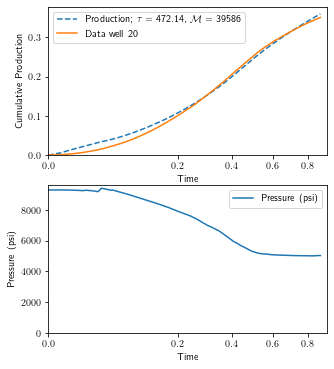

In [18]:
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
# This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
fig,(ax1,ax2)=plot_production_comparison(
    D,
    pvt_gas,
    result.params,
    filter_window_size=30,
    well_name="Data well "+str(WellNumber),
)
pp=PdfPages('WellsNP'+str(WellNumber)+'.pdf')
pp.savefig(fig)
pp.close()

In [16]:
pkl.dump(Results,file=open("Results.pkl","wb"))